In [10]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import tqdm 
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
from torch.optim.lr_scheduler import MultiStepLR
import predict_module as e

In [11]:
class IdolDataset(Dataset):
    def __init__(self,data_path,setting,transform):
        self.setting = setting
        self.transform = transform
        self.x_data = []
        self.y_data = []

        for i in os.listdir(data_path):
            if not e.is_hidden(i):
                for j in os.listdir(data_path+i):
                    if not e.is_hidden(j):
                        self.x_data.append(data_path+i+'/'+j)
                        self.y_data.append(i)

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, index):
        img = Image.open(self.x_data[index])
        x = self.transform(img)
        y = self.y_data[index]
        return x, y

In [12]:
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
])

In [13]:
data_path = "../train/"
train_set = IdolDataset(data_path, 'train', train_transform)
train_dataloader = DataLoader(train_set, batch_size = 32, shuffle=True)
test_set = IdolDataset(data_path, 'test', test_transform)
test_dataloader = DataLoader(test_set, batch_size = 32, shuffle=True)

In [14]:
batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

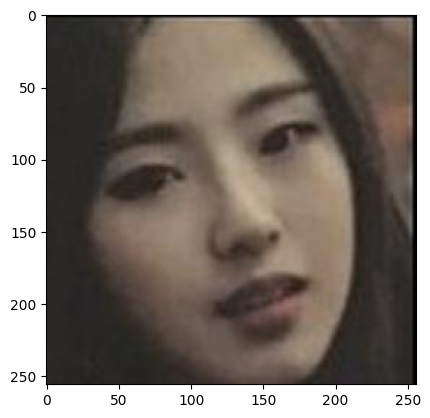

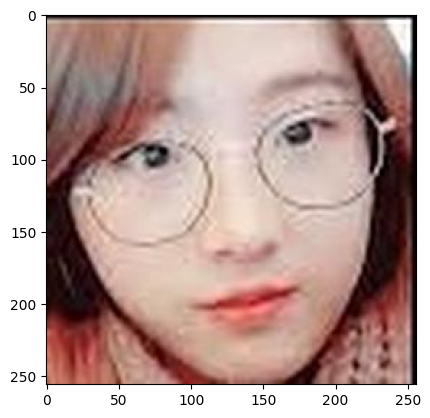

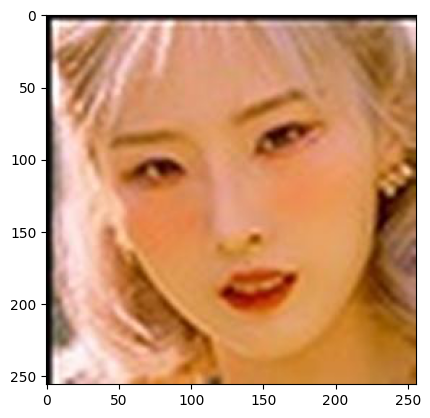

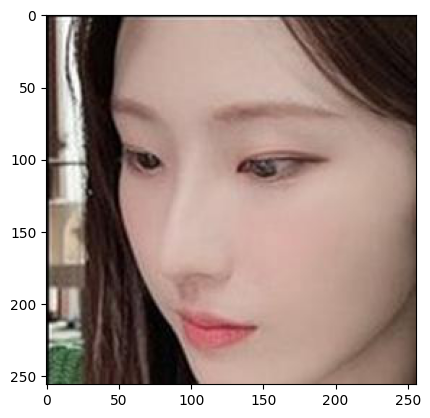

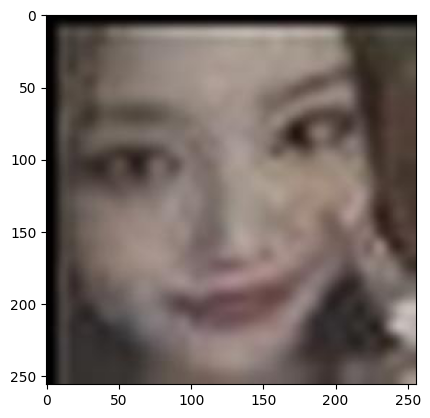

In [15]:
#check dataset images
for i in range(5):
    plt.imshow(to_pil_image(train_set[i][0]))
    plt.show()
    

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cpu


In [17]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [18]:
for i, (x, y) in enumerate(train_dataloader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(train_dataloader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/facenet_pytorch/models/utils/detect_face.py:250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "Min":
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/facenet_pytorch/models/utils/detect_face.py:250: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is "Min":


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(train_set.classes)
).to(device)

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, train_dataloader,
    batch_metrics=metrics, show_running=True, device=device,
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_dataloader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_dataloader,
        batch_metrics=metrics, show_running=True, device=device,
    )
